In [1]:
# Handling the file
import os 

# Storing some numpy features
import pickle

# Preprocess the text
from tensorflow.keras.preprocessing.text import Tokenizer 

# Importing various modules from TensorFlow Keras
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, Embedding, add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Even out the whole text representation feature
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Importing the numpy library as 'np'
import numpy as np 

# Importing the 'tqdm' library for creating progress bars in the user interface
from tqdm.notebook import tqdm 

In [2]:
WORKING_DIR = '/Users/aman/Downloads/Flicker'

LOADING FEATURES

In [3]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'inception_features.pkl'), 'rb') as f:
    features = pickle.load(f)
    

In [4]:
len(features)


8091

#Load the Captions Data


In [5]:
with open(os.path.join(WORKING_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [6]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [7]:
len(mapping)


8091

In [8]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [9]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [10]:
# preprocess the text
clean(mapping)

In [11]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [12]:
# Create an empty list to store all captions
all_captions = []
# Iterate through each key in the mapping dictionary
for key in mapping:
    # Iterate through each caption in the list corresponding to the current key
    for caption in mapping[key]:
        # Append the caption to the all_captions list
        all_captions.append(caption)
        

In [13]:
len(all_captions)


40455

In [14]:
# Creates a Tokenizer object for preprocessing and tokenizing text data.
tokenizer = Tokenizer()

# Fits the Tokenizer onto a list of all captions to build a vocabulary.
# This step assigns a unique integer to each word in the captions.
tokenizer.fit_on_texts(all_captions)

# Determines the size of the vocabulary by counting unique words in the captions
# and adding 1 to account for the special padding token (usually denoted by 0).
vocab_size = len(tokenizer.word_index) + 1


In [15]:
vocab_size


8485

In [16]:
# Access the vocabulary (word to index mapping) created by the Tokenizer
word_index = tokenizer.word_index

# Convert the word_index dictionary to a list of words
vocabulary_words = list(word_index.keys())

# Print the vocabulary words
print(vocabulary_words)

['startseq', 'endseq', 'in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of', 'two', 'white', 'black', 'boy', 'are', 'woman', 'girl', 'to', 'wearing', 'at', 'people', 'water', 'red', 'young', 'brown', 'an', 'his', 'blue', 'dogs', 'running', 'through', 'playing', 'while', 'shirt', 'down', 'standing', 'ball', 'little', 'grass', 'snow', 'child', 'person', 'jumping', 'over', 'three', 'front', 'sitting', 'holding', 'up', 'field', 'small', 'by', 'a', 'large', 'green', 'one', 'group', 'yellow', 'her', 'walking', 'children', 'men', 'into', 'air', 'beach', 'near', 'mouth', 'jumps', 'another', 'for', 'street', 'runs', 'its', 'from', 'riding', 'stands', 'as', 'bike', 'girls', 'outside', 'other', 'off', 'out', 'rock', 'next', 'play', 'orange', 'looking', 'pink', 'player', 'camera', 'their', 'pool', 'hat', 'jacket', 'boys', 'women', 'around', 'behind', 'some', 'background', 'dirt', 'toy', 'soccer', 'sits', 'dressed', 'has', 'wall', 'mountain', 'walks', 'crowd', 'along', 'plays', 'stand', 'look

In [17]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length


35

Train Test Split

In [18]:
import random

# Generates a list of image IDs by extracting keys from a mapping.
image_ids = list(mapping.keys())

# Randomly shuffle the list of image IDs.
random.shuffle(image_ids)

# Calculates split points for dividing the shuffled image IDs into training, testing, and validation sets.
train_split = int(len(image_ids) * 0.8)
test_split = int(len(image_ids) * 0.9)

# Creates a training set containing the first 80% of shuffled image IDs.
train = image_ids[:train_split]

# Creates a testing set containing the next 10% of shuffled image IDs.
test = image_ids[train_split:test_split]

# Creates a validation set containing the last 10% of shuffled image IDs.
validation = image_ids[test_split:]


Data Generator

In [19]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

Model Creation

In [20]:
#importing l2 Regularisation 
from keras.regularizers import l2

# Import the adam optimizer
from tensorflow.keras.optimizers import Adam

# Define the learning rate you want to use
learning_rate = 0.001

# Create the Adam optimizer with the specified learning rate
optimizer = Adam(lr=learning_rate)

# encoder model

# image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(fe1)  #added L2 regularization

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(decoder1) #added L2 regularization
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile the model with the custom optimizer
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

MODEL TRAINING

In [21]:
# Import the EarlyStopping callback from Keras callbacks
from tensorflow.keras.callbacks import EarlyStopping

# Initialize EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=3,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights to the best observed during training
)

# Initialize lists to store training and validation loss and accuracy
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

# train the model
epochs = 30
batch_size = 32
train_steps = len(train) // batch_size
val_steps = len(validation) // batch_size 

for epoch in range(epochs):
    # create data generator
    train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    validation_generator = data_generator(validation, mapping, features, tokenizer, max_length, vocab_size, batch_size)  

    # Modify the model.fit() call to include the EarlyStopping callback
    history = model.fit(
    train_generator,                        # Training data generator
    epochs=1,                               # Train for one epoch at a time
    steps_per_epoch=train_steps,            # Number of training steps per epoch
    validation_data=validation_generator,   # Validation data generator
    validation_steps=val_steps,             # Number of validation steps per epoch
    verbose=1,                              # Print training progress
    callbacks=[early_stopping]              # Include the EarlyStopping callback
)

    # Append training loss and accuracy to the respective lists
    train_losses.extend(history.history['loss'])
    train_accuracies.extend(history.history['accuracy'])

    # Get validation loss and accuracy
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    
    # Append validation loss and accuracy to the respective lists
    validation_losses.extend(val_loss)
    validation_accuracies.extend(val_accuracy)

    # Display the current epoch number, validation loss, and accuracy
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Validation Loss: {val_loss[-1]}, Validation Accuracy: {val_accuracy[-1]}")

202/202 [==============================] - 231s 1s/step - loss: 7.7126 - accuracy: 0.0953 - val_loss: 5.8676 - val_accuracy: 0.0980
Epoch 1/30
Validation Loss: 5.867611408233643, Validation Accuracy: 0.09804642200469971
202/202 [==============================] - 220s 1s/step - loss: 5.5895 - accuracy: 0.1257 - val_loss: 5.4806 - val_accuracy: 0.1408
Epoch 2/30
Validation Loss: 5.48057746887207, Validation Accuracy: 0.14079466462135315
202/202 [==============================] - 225s 1s/step - loss: 5.3042 - accuracy: 0.1474 - val_loss: 5.3035 - val_accuracy: 0.1563
Epoch 3/30
Validation Loss: 5.303465843200684, Validation Accuracy: 0.15628600120544434
202/202 [==============================] - 227s 1s/step - loss: 5.0497 - accuracy: 0.1757 - val_loss: 5.0607 - val_accuracy: 0.1896
Epoch 4/30
Validation Loss: 5.060718536376953, Validation Accuracy: 0.1895727664232254
202/202 [==============================] - 231s 1s/step - loss: 4.8456 - accuracy: 0.1909 - val_loss: 4.9648 - val_accurac

SAVING MODEL

In [22]:
# save the model
model.save(WORKING_DIR+'/InceptionV3/Experiment_2/Exp_2')


INFO:tensorflow:Assets written to: /Users/aman/Downloads/Flicker/InceptionV3/Experiment_2/Exp_2/assets


INFO:tensorflow:Assets written to: /Users/aman/Downloads/Flicker/InceptionV3/Experiment_2/Exp_2/assets


In [23]:
# Save training history
history_dict = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'validation_accuracies':validation_accuracies,
    'validation_losses':validation_losses
    
}

pickle.dump(history_dict, open(os.path.join(WORKING_DIR, 'InceptionV3/Experiment_2/exp2_Hist.pkl'), 'wb'))


LOADING MODEL

In [24]:
from tensorflow.keras.models import load_model

 # Define the path to the saved model
model_path = WORKING_DIR +  '/InceptionV3/Experiment_2/Exp_2'

 # Load the model
model = load_model(model_path)


2023-10-25 21:09:36.418403: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-10-25 21:09:36.429894: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-10-25 21:09:36.503750: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-10-25 21:09:36.507918: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-10-25 21:09:36.911194: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 13 outputs but the _output_sh

LOADING MODEL HISTORY

In [25]:
# Load training history from pickle file
with open(os.path.join(WORKING_DIR, 'InceptionV3/Experiment_2/exp2_Hist.pkl'), 'rb') as f:
    loaded_history = pickle.load(f)

# You can now access the loaded history dictionary like this:
train_losses = loaded_history['train_losses']
train_accuracies = loaded_history['train_accuracies']
validation_accuracies = loaded_history['validation_accuracies']
validation_losses = loaded_history['validation_losses']


Visualisaiton of Train and Test

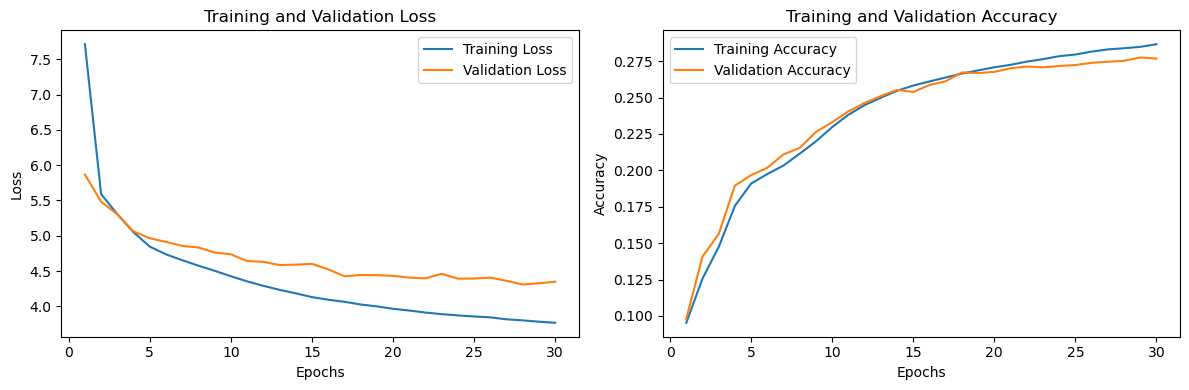

In [26]:
import matplotlib.pyplot as plt

# Mention the epochs number
epochs = 30

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Generate Captions for the Image

In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [28]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

BLEU SCORE

In [29]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# Calculate BLEU scores
bleu_1_score = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
bleu_2_score = corpus_bleu(actual, predicted, weights=(0.5, 0.5))

# Print BLEU scores
print("BLEU-1: %f" % bleu_1_score)
print("BLEU-2: %f" % bleu_2_score)


  0%|          | 0/809 [00:00<?, ?it/s]

BLEU-1: 0.353453
BLEU-2: 0.197133



SAVING THE BLUE SCORE


In [30]:
# Save the BLEU scores to a text file
with open(os.path.join(WORKING_DIR,'InceptionV3/Experiment_2/BLEU.txt'), 'w') as file:
    file.write(f"BLEU-1: {bleu_1_score}\n")
    file.write(f"BLEU-2: {bleu_2_score}\n")
    

LOADING THE BLUE SCORE


In [31]:
# Open the file for reading
with open(os.path.join(WORKING_DIR,'InceptionV3/Experiment_2/BLEU.txt'), 'r') as file:
    # Read the content of the file line by line
    file_contents = file.readlines()

# Print the contents
for line in file_contents:
    print(line.strip())  # Use strip() to remove leading/trailing whitespace and newline characters
    

BLEU-1: 0.35345255837059114
BLEU-2: 0.19713263568272205


Visualize the Results

In [32]:
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(WORKING_DIR, "images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        # Split the caption into words
        words = caption.split()
        
        # Remove the first and last word beacuse all the models were trained on the captions having two words
        # 'startseq'in the begging and two 'endseq' and at the end, doing so doesn't affect the model's output
        # training all the models is very computational therefore this was done
        trimmed_caption = ' '.join(words[1:-1])
        
        print(trimmed_caption)
    
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')

    # Split the predicted caption into words
    pred_words = y_pred.split()

     # Remove the first and last word beacuse all the models were trained on the captions having two words
     # 'startseq'in the begging and two 'endseq' and at the end, doing so doesn't affect the model's output
     # training all the models is very computational therefore this was done
    trimmed_pred_caption = ' '.join(pred_words[1:])

    print(trimmed_pred_caption)

    plt.imshow(image)


---------------------Actual---------------------
girl is stretched out in shallow water
girl wearing red and multi-colored bikini is laying on her back in shallow water
little girl in red swimsuit is laying on her back in shallow water
"a young girl is lying in the sand while ocean water is surrounding her ."
girl wearing bikini lying on her back in shallow pool of clear blue water
--------------------Predicted--------------------
two children are playing in the water endseq


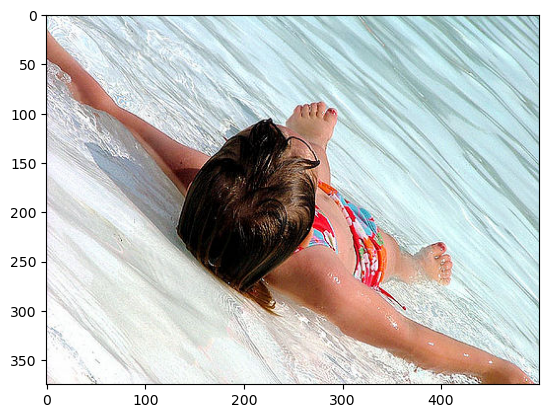

In [ ]:
from PIL import Image

generate_caption("667626_18933d713e.jpg")